[View in Colaboratory](https://colab.research.google.com/github/agerk/google_ml_crash_course/blob/master/Cat_vs_Dog_PretrainedModel_FeatureExtraction_Part3.ipynb)

<h2>Feature Extraction and Fine-Tuning Using Inception V3</h2>

- Repurposing feature data generated from image models that have already been trained on large dataset to increase model accuracy

<h3>Feature Extraction Using a Pretrained Model </h3>

- In computer vision, commonly model trained on large dataset, is used to extract intermdediate representations and use them tonew model with smaller dataset. This veratility and repurposability of convnets is one of the most intersting aspect of deep learning. 

- To imporve Cat-vs-Dog image classifier, [Inception V3 model](https://arxiv.org/abs/1512.00567) developed at Google, and pre-trained on [ImageNet](http://image-net.org/), a large dataset of web images (1.4M images and 1000 classes) will be used.

- Common practice it to use the very last layer before `Flattening` operation, the so called "bottleneck layer". 
- Unlike the `Fully` connected layer, the bottleneck features retain much generality

In [1]:
# Load liberaries
import os

# Load DL liberaries
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from keras import layers
from keras.models import Model
from keras.optimizers import RMSprop
from keras import backend as K

# Configure TF backend session
tf_config = tf.ConfigProto(
  gpu_options=tf.GPUOptions(allow_growth=True))
K.set_session(tf.Session(config=tf_config))

Using TensorFlow backend.


In [2]:
# Download pretrained weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
print("Done loading weights!")

--2018-06-02 01:38:23--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 2607:f8b0:4001:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   103MB/s    in 0.8s    

2018-06-02 01:38:24 (103 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Done loading weights!


In [0]:
# Get local copy 
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
# Specify include_top=False, exclude the top layer
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

Make model non-trainable, since we will only use it for `feaure extraction`. No updates to the weights of the pretrained model

In [0]:
# Make model weights non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

For feature extraction of Inception v3, use layer `mixed7`. It is not the bottleneck of the network, but we use it to keep large features (7x7), instead of the the bottleneck layer with 3x3 features

In [5]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


Add a fully connected classifier on top of last_output

In [0]:
# Flatten the output to 1D
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation 
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification 
x = layers.Dense(1, activation='sigmoid')(x)

# Configuration and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=0.0001),
            metrics=['acc'])

<h2>Data Prepocessing</h2>

The 2,000 images used in Part 2 https://github.com/agerk/google_ml_crash_course/blob/master/Cat_vs_Dog_image_classification_Part2.ipynb excerpted from the 'Dogs vs. Cats' dataset available on Kaggle

In [7]:
# Load data
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

--2018-06-02 01:38:43--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 2607:f8b0:4001:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  74.2MB/s    in 0.9s    

2018-06-02 01:38:44 (74.2 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


In [0]:
# Defie train and validation dirs
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
validation_cats_dir = os.path.join(validation_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Get file name 
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

<h3>Data augmentation</h3>

In [10]:
from keras.preprocessing.image import ImageDataGenerator

# Add data-augmentation parameter to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# validation data should not be agumented
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow trainging images for batch processing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# Flow validation images in batches of 20 using test_datagen
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<h3> Train the model</h3>

Train the model using extracted features for 2 epochs

In [11]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2)

Epoch 1/2
 - 29s - loss: 0.5052 - acc: 0.7725 - val_loss: 0.1495 - val_acc: 0.9530
Epoch 2/2
 - 24s - loss: 0.3819 - acc: 0.8380 - val_loss: 0.1541 - val_acc: 0.9580


Validation accuracy impoved very quickly! Much better than the base model

<h2>Further Improving Accuracy with Fine-Tuning</h2>

Notes: 
- goal of fine-tuning is to adapt the pretrained model specialized features to work with the new dataset
- fine-tuning the weight of pretrained network would increase performance 
- **fine-tuning should only be attempted after training the top-level calssifier of the pretrained model**, since the higher-up layers is, the more specialized it it. 
- The features of higher-up layers are specific to the input the model was trained on.  

In [0]:
# Implement fine-tuning by setting the top layers of Inception V3 "trainable"
unfreez = False

# Unfreeze all models belonging to "mixed7" i.e,
# all layer found after "mixed6" and recompile the updated model
for layer in pre_trained_model.layers:
  if unfreez:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreez = True

from keras.optimizers import SGD

# As an optimizer, here we will use SGD
# with a very small learning rate (0.00001)
model.compile(loss='binary_crossentropy',
             optimizer=SGD(lr=0.00001, momentum=0.9),
             metrics=['acc'])


In [15]:
# Retrain the model using all 2000 images for 50 epochs
# and validate on all 1,000 test images

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/50
 - 29s - loss: 0.3977 - acc: 0.8315 - val_loss: 0.1834 - val_acc: 0.9550
Epoch 2/50
 - 24s - loss: 0.3290 - acc: 0.8635 - val_loss: 0.1950 - val_acc: 0.9510
Epoch 3/50
 - 24s - loss: 0.2952 - acc: 0.8675 - val_loss: 0.2034 - val_acc: 0.9480
Epoch 4/50
 - 24s - loss: 0.2906 - acc: 0.8680 - val_loss: 0.2098 - val_acc: 0.9450
Epoch 5/50
 - 25s - loss: 0.2990 - acc: 0.8730 - val_loss: 0.2156 - val_acc: 0.9440
Epoch 6/50
 - 24s - loss: 0.2900 - acc: 0.8725 - val_loss: 0.2167 - val_acc: 0.9440
Epoch 7/50
 - 25s - loss: 0.2883 - acc: 0.8685 - val_loss: 0.2180 - val_acc: 0.9450
Epoch 8/50
 - 24s - loss: 0.2873 - acc: 0.8740 - val_loss: 0.2159 - val_acc: 0.9450
Epoch 9/50
 - 25s - loss: 0.2875 - acc: 0.8710 - val_loss: 0.2198 - val_acc: 0.9440
Epoch 10/50
 - 24s - loss: 0.2812 - acc: 0.8695 - val_loss: 0.2215 - val_acc: 0.9430
Epoch 11/50
 - 25s - loss: 0.2741 - acc: 0.8785 - val_loss: 0.2195 - val_acc: 0.9440
Epoch 12/50
 - 24s - loss: 0.2829 - acc: 0.8700 - val_loss: 0.2209 - val_a

Epoch 35/50
 - 24s - loss: 0.2830 - acc: 0.8740 - val_loss: 0.2358 - val_acc: 0.9410
Epoch 36/50
 - 24s - loss: 0.2985 - acc: 0.8685 - val_loss: 0.2356 - val_acc: 0.9420
Epoch 37/50
 - 24s - loss: 0.2705 - acc: 0.8880 - val_loss: 0.2331 - val_acc: 0.9420
Epoch 38/50
 - 24s - loss: 0.2638 - acc: 0.8865 - val_loss: 0.2302 - val_acc: 0.9420
Epoch 39/50
 - 23s - loss: 0.2774 - acc: 0.8785 - val_loss: 0.2323 - val_acc: 0.9420
Epoch 40/50
 - 24s - loss: 0.2777 - acc: 0.8725 - val_loss: 0.2329 - val_acc: 0.9420
Epoch 41/50
 - 24s - loss: 0.2680 - acc: 0.8830 - val_loss: 0.2346 - val_acc: 0.9410
Epoch 42/50
 - 24s - loss: 0.2785 - acc: 0.8740 - val_loss: 0.2369 - val_acc: 0.9410
Epoch 43/50
 - 23s - loss: 0.2818 - acc: 0.8715 - val_loss: 0.2405 - val_acc: 0.9410
Epoch 44/50
 - 23s - loss: 0.2777 - acc: 0.8755 - val_loss: 0.2425 - val_acc: 0.9420
Epoch 45/50
 - 23s - loss: 0.2652 - acc: 0.8820 - val_loss: 0.2399 - val_acc: 0.9410
Epoch 46/50
 - 23s - loss: 0.2778 - acc: 0.8735 - val_loss: 0.240

Validation accuracy showed 4.5% relative imporvment in accuracy. 

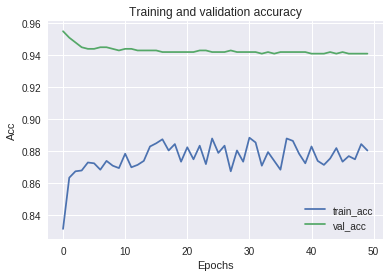

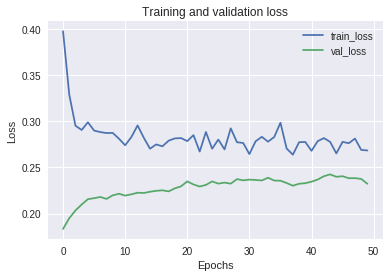

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and 
# test data for each epoch
train_acc = history.history['acc']
val_acc = history.history['val_acc']

# Retriev loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get num of epochs
epochs = range(len(train_acc))

# Plot training and validation accuracy
plt.plot(epochs, train_acc, label='train_acc')
plt.plot(epochs, val_acc, label='val_acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.figure()

# Plot training and validation loss
plt.plot(epochs, train_loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
plt.close()


In [0]:
# Clean up colab
import os, signal
ok.kill(os.getpid(), signla.SIGKILL)

*This tutorial was inspired by Google ML crash course *